googledrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CIND820
!pwd

# Final Project : Forecasting Hourly Electricity Demand for Ontario

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Problem Decsription</h2>
</div>


Goal:

- To Predict Hourly Electricity Demand for Ontario using SARIMAX technique
- Tune and evaluate the model
- Compare  Machine learning Approach with SARIMAX technique

Dataset description:

- The dataset provides a 10-year sector-aggregated  hourly electricity demand in Ontario from January 2008 to December 2018.
- Hourly weather dataset obtained to investigate the eefect of temperature and other wether conditions on Electricity demand


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Load the Data</h2>
</div>



- Import the libraries
- Load the dataset


**1.1  Importing Libraries**

Install Packages

In [ ]:
!pip install sktime
!pip install pmdarima
!pip install dcor

Import Libraries

In [38]:
# Import libraries 

# Data Manipulation
import numpy as np 
import pandas as pd
from   pandas import DataFrame

# Models
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.forecasting.compose import TransformedTargetForecaster

# Evaluation metrics

from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError ,MeanSquaredError,MeanAbsoluteError

# time model
import time


from sktime.forecasting.arima import AutoARIMA

# ML Models

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# import necessary Python packages
import statsmodels.api as sm
from pmdarima import auto_arima



# Data Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import dcor # correlation for exog

# Import plot_acf() function
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### 1.2  Load datasets

- Download and save weather dataset
- Download and save electricity load datset
    
    - create additional features : timestamp, month, year, season
    - merge weather and load demand 

In [ ]:
# Download and save weather data

import shutil
import requests

def save_to_disk(url, filepath):
    response = requests.get(url, stream=True)
    
    with open(filepath, 'wb') as f:
        shutil.copyfileobj(response.raw, f)

    del response

# save data
    
url = 'https://www.renewables.ninja/country_downloads/CA/ninja_weather_country_CA.ON_merra-2_population_weighted.csv'
filepath = 'weatherdata.csv'
save_to_disk(url, filepath)

In [14]:
# define season function


def getSeason(month):
    """adding season using the modified inforamtion  on 
    https://settlement.org/ontario/housing/living-in-ontario/housing-basics/what-is-the-weather-like-in-ontario; 
    """    
    
    month = int(month)
    if (month == 12 or month == 1 or month == 2 or month == 3):
        return "Winter"
    
    elif(month == 4 or month == 5):
        return "Spring"
    elif(month ==6 or month==7 or month == 8 or month == 9):
        return "Summer"
    else:
        return "Fall"





# Load and merge weather and consumpption data

def loadfileCombine(startyear = 2008, stopyear = 2018):
    
    
    datafile = pd.DataFrame({'Date':[],'Hour':[],'Ontario Demand':[]}) # initialize empty file
    
    for year in range(startyear, stopyear+1):
        filepath = "http://reports.ieso.ca/public/Demand/PUB_Demand_{}.csv".format(year)
        df =  pd.read_csv(filepath, skiprows= [0,1,2], usecols = lambda x: x in ['Date','Hour','Ontario Demand'],parse_dates=["Date"]) # skip rows 0,1,2
        datafile = pd.concat([datafile,df], axis = 0)
        
    
    # adding extra attributes
    datafile["Year"] = datafile["Date"].dt.year
    datafile["Month"] = datafile["Date"].dt.month
    datafile["season"] = datafile["Date"].dt.month.apply(getSeason)
    datafile["timestamp"] = datafile["Date"].add(pd.to_timedelta(datafile.Hour - 1, unit="h")) # create timestamp variable from Date and Hour
    
    
    datafile.index = range(len(datafile)) # to have correct index
    datafile = datafile.rename(columns={"Ontario Demand": "load"})
    
    # loading weather data
    df_w = pd.read_csv("weatherdata.csv", parse_dates=["time"],skiprows=[0,1])
    weatherfile = df_w[(df_w.time >= str(startyear)) & (df_w.time < str(stopyear+1))]
    weatherfile.index = range(len(weatherfile)) # for correct index
    
    # merging the two files
    
    data = pd.merge(datafile, weatherfile, left_on="timestamp", right_on = "time", suffixes=(False,False), how ='inner',validate="1:1")
    
    data = data[["timestamp","Date","load","Year","Month","Hour","season","temperature","precipitation","irradiance_surface","irradiance_toa","snowfall","snow_mass","cloud_cover","air_density" ]]
    
    # save to csv
    data.to_csv("loadDemand.csv",index=False) #, index=False
    return data


In [19]:
# Load Merged Data
loadDemand=loadfileCombine()
loadDemand.head()

,timestamp,Date,load,Year,Month,Hour,season,temperature,precipitation,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density
0,2008-01-01 00:00:00,2008-01-01,15181.0,2008,1,1.0,Winter,-2.953,0.0133,0.0,0.0,0.0115,19.1040,0.7362,1.2682
1,2008-01-01 01:00:00,2008-01-01,14610.0,2008,1,2.0,Winter,-3.182,0.0236,0.0,0.0,0.0196,19.1223,0.8193,1.2677
2,2008-01-01 02:00:00,2008-01-01,14151.0,2008,1,3.0,Winter,-3.341,0.0397,0.0,0.0,0.0317,19.1515,0.8710,1.2672
3,2008-01-01 03:00:00,2008-01-01,13926.0,2008,1,4.0,Winter,-3.403,0.0647,0.0,0.0,0.0531,19.1988,0.8863,1.2669
4,2008-01-01 04:00:00,2008-01-01,13670.0,2008,1,5.0,Winter,-3.309,0.1067,0.0,0.0,0.0949,19.2799,0.9022,1.2669


In [ ]:
loadDemand.tail()

,timestamp,Date,load,Year,Month,Hour,season,temperature,precipitation,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density
96427,2018-12-31 19:00:00,2018-12-31,16195.0,2018,12,20.0,Winter,1.083,0.1507,59.7524,394.0457,0.0060,5.0842,0.9754,1.2537
96428,2018-12-31 20:00:00,2018-12-31,15668.0,2018,12,21.0,Winter,0.907,0.2605,26.0538,237.2322,0.0175,5.0672,0.9799,1.2518
96429,2018-12-31 21:00:00,2018-12-31,14987.0,2018,12,22.0,Winter,0.753,0.5407,4.5386,52.4387,0.0721,5.0880,0.9829,1.2500
96430,2018-12-31 22:00:00,2018-12-31,14560.0,2018,12,23.0,Winter,0.557,0.6845,0.0105,0.0360,0.0818,5.1586,0.9807,1.2492
96431,2018-12-31 23:00:00,2018-12-31,13828.0,2018,12,24.0,Winter,0.780,1.2726,0.0000,0.0000,0.3701,5.3608,0.9841,1.2462


In [ ]:
loadDemand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96432 entries, 0 to 96431
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           96432 non-null  datetime64[ns]
 1   Date                96432 non-null  datetime64[ns]
 2   load                96432 non-null  float64       
 3   Year                96432 non-null  int64         
 4   Month               96432 non-null  int64         
 5   Hour                96432 non-null  float64       
 6   season              96432 non-null  object        
 7   temperature         96432 non-null  float64       
 8   precipitation       96432 non-null  float64       
 9   irradiance_surface  96432 non-null  float64       
 10  irradiance_toa      96432 non-null  float64       
 11  snowfall            96432 non-null  float64       
 12  snow_mass           96432 non-null  float64       
 13  cloud_cover         96432 non-null  float64   

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Overview of the Data</h2>
</div>

To have a good understanding of data.


- Get the descriptive statistics of the data
- Get the information about missing values in the data

### 2.1. Descriptive Statistics

Descriptive statistics describes the data. It gives  information about
- Mean, median, mode 
- Min, max
- Count etc



In [ ]:
# Dimension of the data
loadDemand.shape

(96432, 15)

In [ ]:
# Attributes of the dataset
loadDemand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96432 entries, 0 to 96431
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           96432 non-null  datetime64[ns]
 1   Date                96432 non-null  datetime64[ns]
 2   load                96432 non-null  float64       
 3   Year                96432 non-null  int64         
 4   Month               96432 non-null  int64         
 5   Hour                96432 non-null  float64       
 6   season              96432 non-null  object        
 7   temperature         96432 non-null  float64       
 8   precipitation       96432 non-null  float64       
 9   irradiance_surface  96432 non-null  float64       
 10  irradiance_toa      96432 non-null  float64       
 11  snowfall            96432 non-null  float64       
 12  snow_mass           96432 non-null  float64       
 13  cloud_cover         96432 non-null  float64   

Checking the number of rows in each year  

Leap years have 8784 rows, others are 8760 rows

In [ ]:
# Checking the number of rows in each year  

# Leap years have 8784 rows, others are 8760 rows

loadDemand.groupby(loadDemand['Date'].dt.year).count()

,timestamp,Date,load,Year,Month,Hour,season,temperature,precipitation,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density
Date,,,,,,,,,,,,,,,
2008,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784
2009,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760
2010,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760
2011,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760
2012,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784
2013,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760
2014,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760
2015,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760,8760
2016,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784,8784


In [ ]:
# Summary of the dataset

loadDemand.describe()

,load,Year,Month,Hour,temperature,precipitation,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density
count,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000
mean,15937.287467,2012.999253,6.522648,12.500000,7.876173,0.089161,169.711619,311.145342,0.016880,4.244066,0.547828,1.225421
std,2440.990358,3.162491,3.448798,6.922222,11.190645,0.187106,245.394379,392.330561,0.064482,8.034672,0.308512,0.053838
min,10167.000000,2008.000000,1.000000,1.000000,-27.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.102600
25%,14120.000000,2010.000000,4.000000,6.750000,-0.873000,0.005700,0.000000,0.000000,0.000000,0.000000,0.266775,1.179700
50%,15919.000000,2013.000000,7.000000,12.500000,7.969000,0.022400,8.631850,37.462000,0.000100,0.018600,0.576600,1.221000
75%,17570.250000,2016.000000,10.000000,18.250000,17.305000,0.083100,288.720875,601.869750,0.006900,5.363525,0.837100,1.265800
max,25450.000000,2018.000000,12.000000,24.000000,33.329000,4.334800,994.833100,1229.858500,2.217900,42.769400,0.997000,1.412300


### 2.2. Missing Values

Get the info about missing values in the dataframe

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Exploratory Data Analaysis</h2>
</div>


Goal : 
    To analyze or investigate data sets to find out patterns in the data. Visual methods will be used to summarise the data.
    Primarily to see what the data can tell us beyond the formal modeling or hypothesis testing tasks.

Steps:

- Visualize the time series using line plot
- Check distribution of the time series
- Check mean hourly variation in consumption 
- Check monthly seasonality using multiple lines. 
- Check monthly seasonality and yearly trend using box plot
- Decompose the time series
- Stationarity test - Augmented Dickey Fuller test (ADH Test) and KPSS test
- ACF-PACF plots and Find the order of differencing 

### 3.1. Visualize the time series using line plot

A line plot of a time series  provides a lot of insights into the problem. 
Some observations from the plot  include:

- fluctuations in electricity consumption throughout the year
- a seeminly repeated patterns of consumption
- absence of no obvious outliers

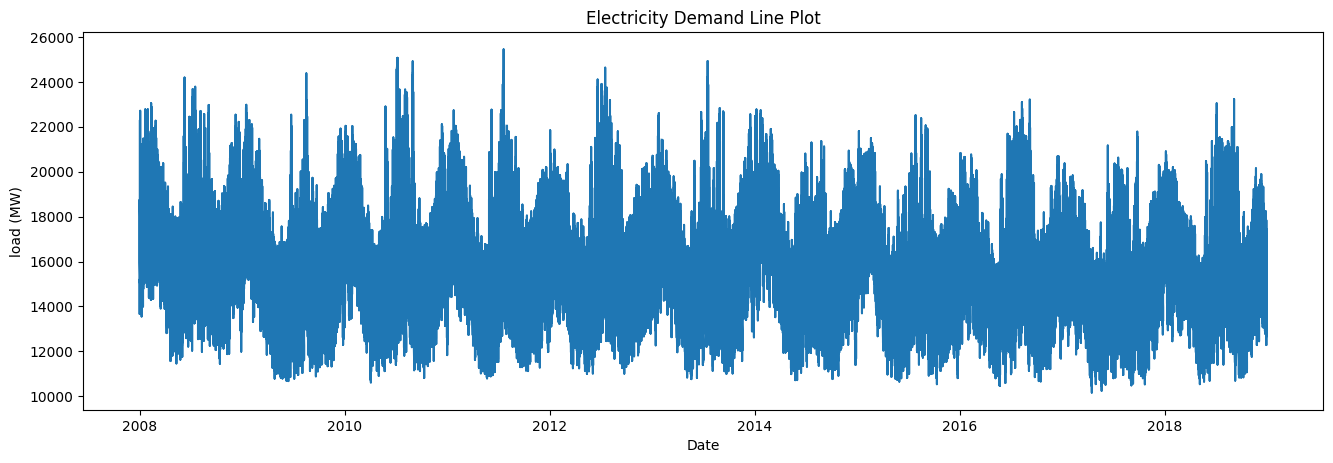

In [ ]:
# Draw line Plot
def plot_df(x, y, title="", xlabel='Date', ylabel='load (MW)', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=loadDemand.Date, y=loadDemand.load, title='Electricity Demand Line Plot')

### 3.2. Check distribution of load demand

Could be observed that:
- most demand between ~1200 to ~1800 MW of electricity
- maximum demand around ~2500 MW

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


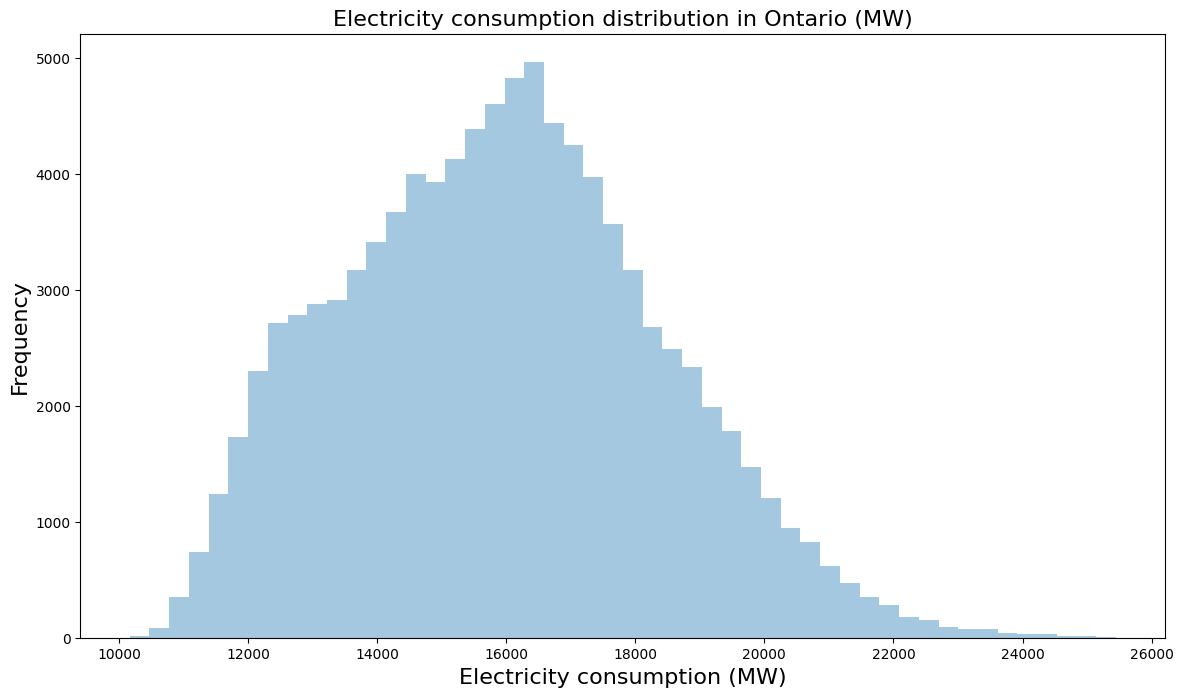

In [ ]:
plt.figure(figsize=(14,8), dpi=100)

sns.distplot(loadDemand["load"], kde = False) #, color ='blue', bins = 20

plt.title('Electricity consumption distribution in Ontario (MW)', fontsize=16)
plt.xlabel('Electricity consumption (MW)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

### 3.2. Check Mean hourly variation in elctricity consumption

observations:

- 2 peak demand periods identified
- 1st peak bewteen 9:00am to 2:00pm : may be driven mainly by industrial/commercial sector consumptions
- 2nd peak around 1800 hrs to 2100hrs : this additional contribution may be due to residential consumption as many people will be returning from work at this time 
- lowest consumption between 2200hrs to 0600hrs when people are sleeping and few industries are operating

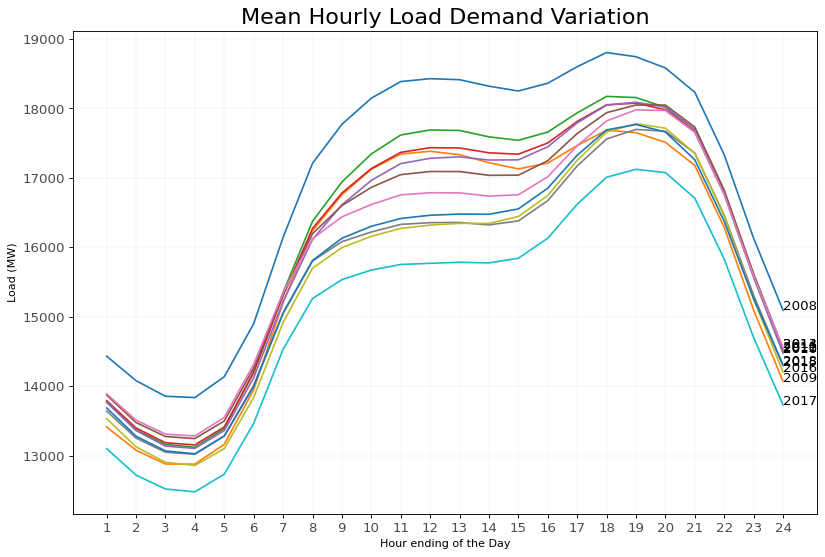

In [ ]:
plt.figure(figsize=(12,8), dpi= 80)
for year in loadDemand.Year.unique():
    df = loadDemand.set_index('timestamp').loc[str(year)]
    plt.plot(df.Hour.unique(),[df.load[df.Hour==i].mean() for i in df.Hour.unique()])
    plt.text(df.Hour.unique()[-1],[df.load[df.Hour==i].mean() for i in df.Hour.unique()][-1], year, fontsize=12)
 

plt.gca().set(ylabel= 'Load (MW)', xlabel = 'Hour ending of the Day')
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(ticks=np.arange(1, 25),fontsize=12, alpha=.7)
plt.title("Mean Hourly Load Demand Variation", fontsize=20)
plt.grid(which='major', axis='both', linewidth=0.1)
plt.show()

###Median ---Add

### 3.2. Check monthly seasonality using multiple lines. 

- The trend over the year tends to be relatively constant with the exceptions of of 2008 and 2018
- some dropping tendencies observed from 20015 downwards, may be attributed to availablity of possible alternative choices such as solar etc or more efficieny in enegy utilization
- 2010 to 2014 relatively remains flat

- High consumption observed between June and September, and December to March: may be attributed to cooling required during the hot summer and heating required in Winter period
- Average Winter consumption is slightly higher than in summer, an indication that more energy is consumed in heating in winter compared to cooling during summer
- Consumption is least in Spring

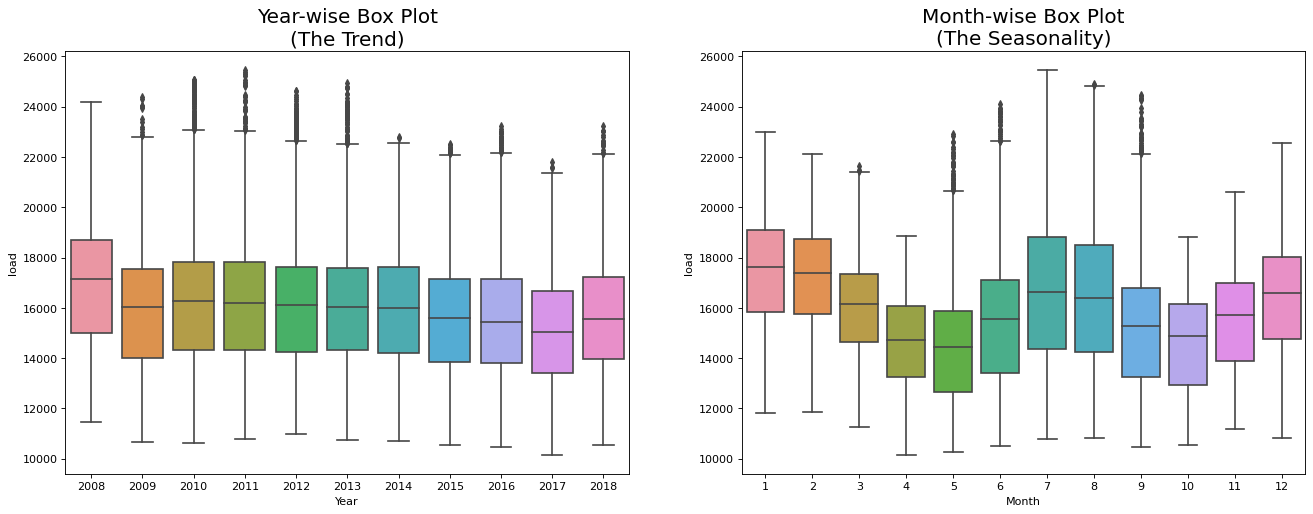

In [ ]:

df = loadDemand
years = df.Year.unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='load', data=df, ax=axes[0])
sns.boxplot(x='Month', y='load', data=df.loc[~df.Year.isin([2008, 2018]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

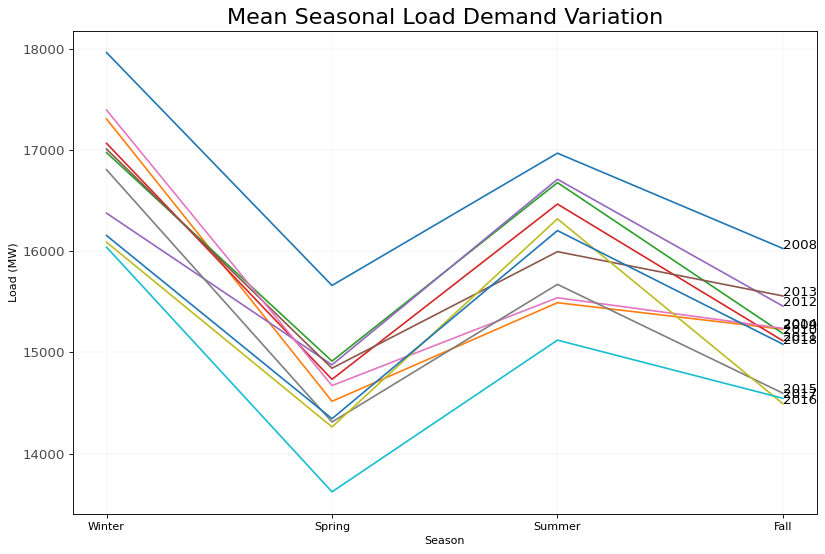

In [ ]:
plt.figure(figsize=(12,8), dpi= 80)
for year in loadDemand.Year.unique():
    df = loadDemand.set_index('timestamp').loc[str(year)]
    plt.plot(df.season.unique(),[df.load[df.season==i].mean() for i in df.season.unique()])
    plt.text(df.season.unique()[-1],[df.load[df.season==i].mean() for i in df.season.unique()][-1], year, fontsize=12)
 

plt.gca().set(ylabel= 'Load (MW)', xlabel = 'Season')
plt.yticks(fontsize=12, alpha=.7)

plt.title("Mean Seasonal Load Demand Variation", fontsize=20)
plt.grid(which='major', axis='both', linewidth=0.1)
plt.show()

### 3.3. Check variation with External variables 

observations:

- The top 3 highly correlated variables with electricity demand are snow_mass(0.62), temperature (0.60), air_density (0.6)
- However, there is very high correlation between temperature and snow_mass(-0.83)  and temperature and air_density (-0.97), snow_mass and air_density (0.79)
- With the above, eliminating the highly correlated variables, we keep temperature as the only exogenous variable to investigate.
- It is clear that high demand occurs when temperatures are high due to the effect of air-conditioning 
- There is also a heating effect, where demand increases for very low temperatures.


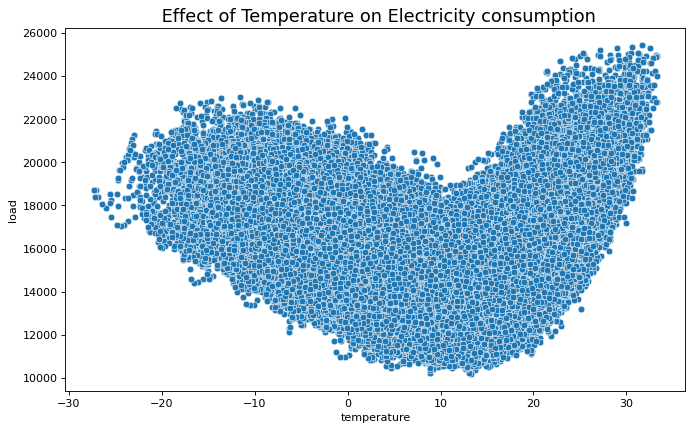

In [ ]:
plt.figure(figsize=(10,6), dpi= 80)
sns.scatterplot(data=loadDemand, x="temperature",y="load")
plt.title(" Effect of Temperature on Electricity consumption", fontsize=16)
plt.show()

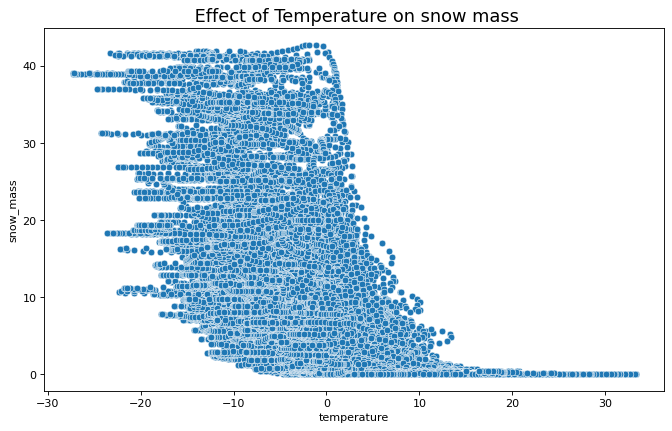

In [ ]:
plt.figure(figsize=(10,6), dpi= 80)
sns.scatterplot(data=loadDemand, x="temperature",y="snow_mass")
plt.title(" Effect of Temperature on snow mass", fontsize=16)
plt.show()

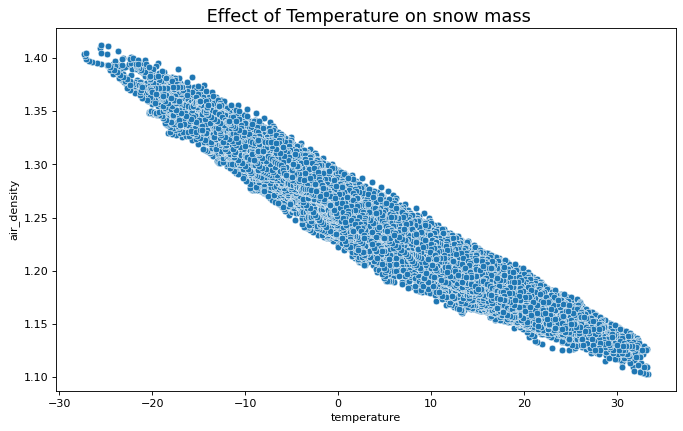

In [ ]:
plt.figure(figsize=(10,6), dpi= 80)
sns.scatterplot(data=loadDemand, x="temperature",y="air_density")
plt.title(" Effect of Temperature on snow mass", fontsize=16)
plt.show()

In [ ]:
# defining functions

def dist_corr(X, Y, pval=True, nruns=2000):
    """ Distance correlation with p-value from bootstrapping
    source: https://mycarta.wordpress.com/2019/04/10/data-exploration-in-python-distance-correlation-and-variable-clustering/
    """
    dc = dcor.distance_correlation(X, Y)
    pv = dcor.independence.distance_covariance_test(X, Y, exponent=1.0, num_resamples=nruns)[0]
    if pval:

        return (dc, pv)

    else:
        return dc
    
# Revised Seaborn pairgrid matrix with distance correlation colored by p-value (gray if p > 0.10, blue if p <= 0.10)
def corrfunc(x, y, **kws):
    d, p = dist_corr(x,y) 
    #print("{:.4f}".format(d), "{:.4f}".format(p))
    if p > 0.05: #0.1
        pclr = 'Darkgray'
    else:
        pclr= 'Darkblue'
    ax = plt.gca()
    ax.annotate("DC = {:.2f}".format(d), xy=(.1, 0.99), xycoords=ax.transAxes, color = pclr, fontsize = 14)

In [20]:
exogdata = loadDemand[["load","temperature","air_density","snow_mass"]]
exogdata.head()

,load,temperature,air_density,snow_mass
0,15181.0,-2.953,1.2682,19.1040
1,14610.0,-3.182,1.2677,19.1223
2,14151.0,-3.341,1.2672,19.1515
3,13926.0,-3.403,1.2669,19.1988
4,13670.0,-3.309,1.2669,19.2799


In [ ]:
g = sns.PairGrid(exogdata, diag_sharey=False)
axes = g.axes
g.map_upper(plt.scatter, linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_upper(corrfunc)
g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
plt.show();

### 3.5. Decompose the energy consumption


- Seasonal compnents could be oberved
- Trend seems constant for the interval being viewed
- The residual does not seem to be stationary




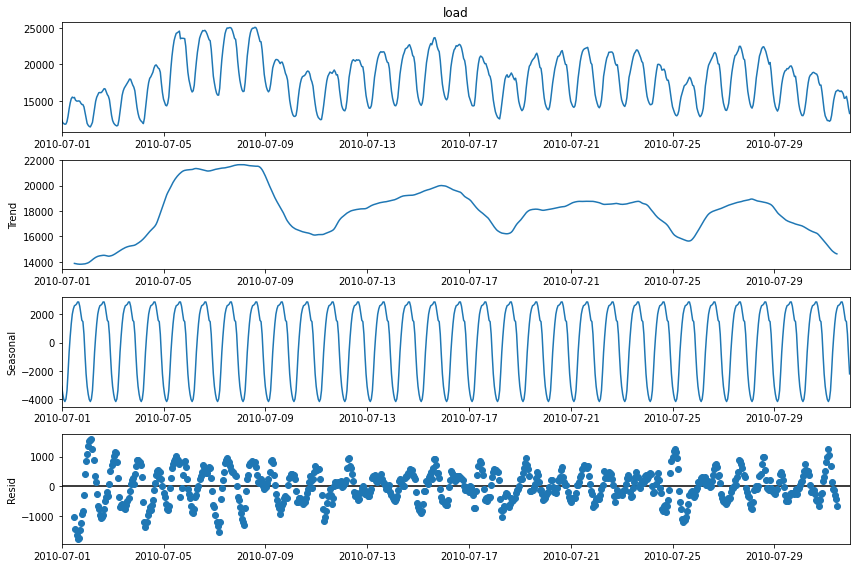

In [ ]:
decomposition = sm.tsa.seasonal_decompose(loadDemand.set_index("timestamp").load['2010-07-01':'2010-07-31'], model = 'additive')

fig = decomposition.plot()
mpl.rcParams['figure.figsize'] = [12.0, 8.0]

### 3.6. Stationarity test - Augmented Dickey Fuller test (ADF Test) and KPSS test

Observations:

- ADF Test shows data is stationary with p-value < 0.05, we reject the Null Hypothesis (Ho = Data is not stationary). We perform KPSS test to check as well.
- KPSS Test: a p-value < 0.05, we reject the Null Hypothesis (Ho = Data is stationary), showing series is not trend stationary.We may use differencing to make it stationary as ADF shows stationary
- Testing KPSS after differencing the data makes it stationary



In [ ]:



from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Test       
        
adf_test(loadDemand['load'],title='Consumption')

Augmented Dickey-Fuller Test: Consumption
ADF test statistic     -1.572544e+01
p-value                 1.308526e-28
# lags used             6.700000e+01
# observations          9.636400e+04
critical value (1%)    -3.430418e+00
critical value (5%)    -2.861570e+00
critical value (10%)   -2.566786e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
# KPSS Test

from statsmodels.tsa.stattools import kpss
result = kpss(loadDemand['load'].values, regression='c',nlags="auto")
print("KPSS Statistic: {}".format(result[0]))
print("P-Value: {}".format(result[1]))
for key, value in result[3].items():
    print("Critial Values: {}, {}".format(key,value))

KPSS Statistic: 5.835798745414911
P-Value: 0.01
Critial Values: 10%, 0.347
Critial Values: 5%, 0.463
Critial Values: 2.5%, 0.574
Critial Values: 1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [ ]:
kpss(loadDemand['load'].diff().dropna().values, regression='c',nlags="auto")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.056158169777557075,
 0.1,
 10048,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

### 3.7 Granger Causality Test

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a
statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

From the result below, the low p-values below 0.05 indicate that temperature can  be useful in forecasting the hourly electricity consumption.

In [ ]:
# Granger Causality Test

from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(loadDemand[['load','temperature']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1416.9180, p=0.0000  , df_denom=96428, df_num=1
ssr based chi2 test:   chi2=1416.9620, p=0.0000  , df=1
likelihood ratio test: chi2=1406.6524, p=0.0000  , df=1
parameter F test:         F=1416.9180, p=0.0000  , df_denom=96428, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2071.7860, p=0.0000  , df_denom=96425, df_num=2
ssr based chi2 test:   chi2=4143.7869, p=0.0000  , df=2
likelihood ratio test: chi2=4057.2247, p=0.0000  , df=2
parameter F test:         F=2071.7860, p=0.0000  , df_denom=96425, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1623.3791, p=0.0000  , df_denom=96422, df_num=3
ssr based chi2 test:   chi2=4870.4910, p=0.0000  , df=3
likelihood ratio test: chi2=4751.4812, p=0.0000  , df=3
parameter F test:         F=1623.3791, p=0.0000  , df_denom=96422, df_num=3


{1: ({'lrtest': (1406.6524490339216, 7.530783738036435e-308, 1),
   'params_ftest': (1416.9179527576669, 7.725606177351726e-308, 96428.0, 1.0),
   'ssr_chi2test': (1416.9620349107593, 4.33070480976814e-310, 1),
   'ssr_ftest': (1416.9179527576684, 7.725606177351726e-308, 96428.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (4057.2247303274926, 0.0, 2),
   'params_ftest': (2071.7860306936323, 0.0, 96425.0, 2.0),
   'ssr_chi2test': (4143.786921229404, 0.0, 2),
   'ssr_ftest': (2071.786030693483, 0.0, 96425.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (4751.481152493274, 0.0, 3),
   'params_ftest': (1623.3791483816713, 0.0, 96422.0, 3.0),
   'ssr_chi2test': (4870.491005145515, 0.0, 3),
   'ssr_ftest': (1623.3791483825432, 0.0, 96422.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

### 3.8. ACF-PACF plots and Find the order of differencing

Reference : https://online.stat.psu.edu/stat510/
          :http://people.duke.edu/~rnau/411arim2.htm



#### Identifying the order of differencing in an ARIMA model
- The series has positive autocorrelations out to a high number of lags.
- This implies clearly at least one order of differencing is needed to stationarize this series.
- ACF plot of 1st order differencing confirms this.

#### Identifying the numbers of AR or MA terms in an ARIMA model
- If the autocorrelation is significant at lag k but not at any higher lags--i.e., if the ACF "cuts off" at lag k--this indicates that exactly k MA terms should be used in the forecasting equatio
- If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms
- The model shows more of 'AR signature' with sharp cutoff in PACF (2) than ACF(with 3 ). Hence, ARIMA(2,1,0) or ARIMA(2,1,3) tc can be tried
- There seems to be a seasonal periodicity of 24hrs here, becos autocorrelation shows peaks every 24hrs
- For the seasonal AR, MA terms, plotting the 24th order seasonal differnce,PACF shows AR(2) pattern, as ACF decays slowly. Hence we can try SARIMA(2,1,3)(2,1,0, 24)





<function matplotlib.pyplot.show>

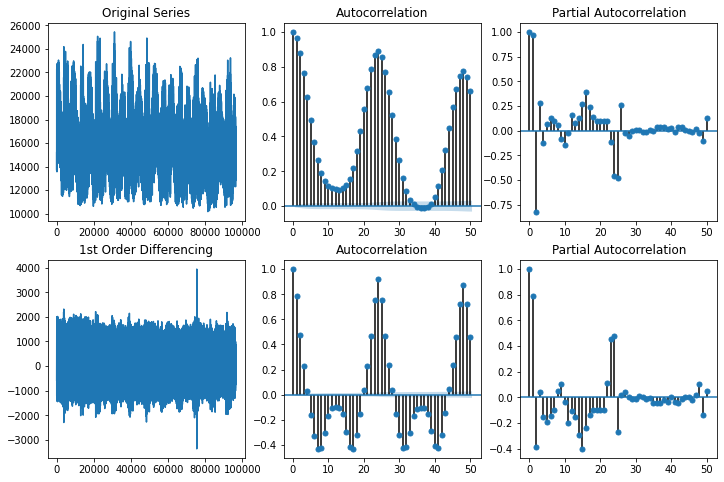

In [ ]:
df = loadDemand
# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(df['load']); axes[0, 0].set_title('Original Series')
plot_acf(df['load'], ax=axes[0, 1])
plot_pacf(df['load'], lags=50, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(df['load'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['load'].diff().dropna(), ax=axes[1, 1])
plot_pacf(df['load'].diff().dropna(), ax=axes[1, 2])

plt.show

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Model Building</h2>
</div>

Since optimisation of model parameters becomes more time consuming because of the number of observations involved, our approach here is to  fit our models to the most recent years. This is often allowed in forecasting  as most time series do not work well for very long time series. Also, it is sometimes unrealistic to assume that seasonal pattern remains the same for nearly over a decade (Hyndman, R.J., 2018).

For computational reasons, focus will be on the last two years of data. Model will be evaluated with the  last 48 hours of the two years for a short term forecast.
- Selecting last two years of the data
- Split data in train-test dataset
- ARIMA Models
 - Model 1 - Non-Seasonal ARIMA Model
 - Model 2 - Seasonal ARIMA Model (SARIMA)
 - Model 3 - Seasonal ARIMA Model with Exogenous variable (SARIMAX)
- Machine Learning Models
    - KNN 
    - LinearRegression
    - RandomForestRegressor
    - DecisionTreeRegressor
    - SVR
- Define function to evaluate models
- Train and evaluate the model


### Selecting Last two years of data   

In [21]:
finaldata = loadDemand[["timestamp","load","temperature"]] ##.drop(columns = ["Date","Year","Month","Hour","season","temperature","precipitation", "irradiance_surface","irradiance_toa",	"snowfall","snow_mass","cloud_cover","air_density"])
finaldata.head() 

,timestamp,load,temperature
0,2008-01-01 00:00:00,15181.0,-2.953
1,2008-01-01 01:00:00,14610.0,-3.182
2,2008-01-01 02:00:00,14151.0,-3.341
3,2008-01-01 03:00:00,13926.0,-3.403
4,2008-01-01 04:00:00,13670.0,-3.309


In [15]:
finaldata = finaldata.set_index("timestamp") #.truncate(before ="2016-01-01")
finaldata=finaldata.truncate(before ="2016-01-01")
finaldata.head()

,load,temperature
timestamp,,
2016-01-01 00:00:00,13417.0,-2.698
2016-01-01 01:00:00,12968.0,-2.785
2016-01-01 02:00:00,12395.0,-2.670
2016-01-01 03:00:00,12228.0,-2.451
2016-01-01 04:00:00,12116.0,-2.403


In [ ]:
finaldata.tail()

,load,temperature
timestamp,,
2018-12-31 19:00:00,16195.0,1.083
2018-12-31 20:00:00,15668.0,0.907
2018-12-31 21:00:00,14987.0,0.753
2018-12-31 22:00:00,14560.0,0.557
2018-12-31 23:00:00,13828.0,0.780


In [ ]:
len(finaldata)

26304

In [22]:
finaldata1 = finaldata[["load","temperature"]]     #.drop(columns = ["timestamp","Year","Month","Hour"])  #energyload.iloc[35065:35067,:]

finaldata1=finaldata1.reset_index(drop=True)
finaldata1.index = pd.Int64Index(finaldata1.index)
finaldata1.head()





,load,temperature
0,15181.0,-2.953
1,14610.0,-3.182
2,14151.0,-3.341
3,13926.0,-3.403
4,13670.0,-3.309


In [23]:
y = finaldata1['load']
X = finaldata1.drop(columns = ["load"])   #.drop(columns = ["Date","load","precipitation"])
y.head()




0    15181.0
1    14610.0
2    14151.0
3    13926.0
4    13670.0
Name: load, dtype: float64

### Splitting Dataset
- Last 48hrs of the data will be used as the test set
- The rest will be the Train test

In [24]:
fh = np.arange(1,49)
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, fh=fh)
X.head()

X_train.shape


(96384, 1)

In [25]:
X_test.shape

(48, 1)

### Non Seasonal Arima Model

- Best orders of ARIMA Model is found by tuning the parameters with `autoarima` function
- Model does not capture seasonal variation in the data

In [ ]:
from pmdarima import auto_arima
import time
t0 = time.time()
model_name='ARIMA'
arima_model = auto_arima(y_train, start_p=1, start_q=0,
                          max_p=10, max_q=5,
                          seasonal=False,
                          d=None, trace=True,random_state=101,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)
arima_model.summary() # Best model:  ARIMA(4,1,3)(0,0,0)[0]  

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=385494.559, Time=3.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=411211.915, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=391246.573, Time=10.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=411209.915, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=381103.590, Time=4.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=381104.491, Time=5.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=379123.346, Time=30.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=381722.221, Time=5.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=381094.176, Time=14.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=377740.171, Time=50.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=381301.727, Time=20.66 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=377759.970, Time=65.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=377685.819, Time=51.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=381297.688, Time=29.99 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                26256
Model:               SARIMAX(4, 1, 3)   Log Likelihood             -187707.240
Date:                Mon, 05 Jul 2021   AIC                         375430.480
Time:                        04:28:12   BIC                         375495.885
Sample:                             0   HQIC                        375451.600
                              - 26256                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2713      0.004    547.551      0.000       2.263       2.279
ar.L2         -2.7502      0.006   -427.706      0.000      -2.763      -2.738
ar.L3          2.1787      0.006    340.704      0.000       2.166       2.191
ar.L4         -0.8519      0.003   -246.162      0.000      -0.859      -0.845
ma.L1         -1.4236      0.005   -303.296      0.000      -1.433      -1.414
ma.L2          1.3980      0.006    233.809      0.000       1.386       1.410
ma.L3         -0.8899      0.005   -181.446      0.000      -0.900      -0.880
sigma2      1.082e+05    554.734    194.974      0.000    1.07e+05    1.09e+05
===================================================================================
Ljung-Box (L1) (Q):                 201.14   Jarque-Bera (JB):            182035.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#train
arima_model.fit(y_train)
t1 = time.time()-t0
#predict
y_pred = arima_model.predict(n_periods=48)
print('SMAPE: ',smape(y_test, y_pred))
print("Execution time: ", t1)

SMAPE:  0.05259933832882966
Execution time:  1414.3485062122345


In [ ]:
#y_train.index=pd.Int64Index(data=y_train.index)
y_pred = pd.Series(y_pred) # convet ndarray to pd series
y_pred.index = y_test.index

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd98ef96450>)

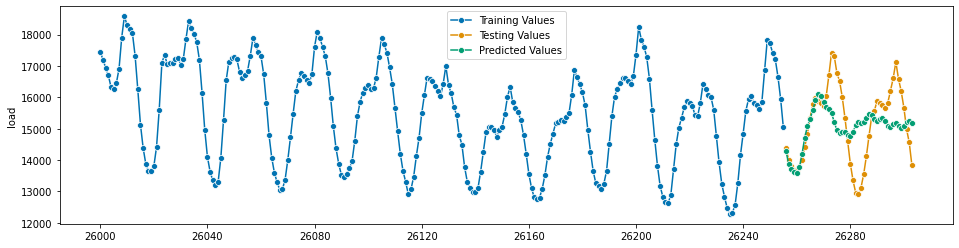

In [ ]:


plot_series(y_train[26000:], y_test,y_pred , labels = ["Training Values", "Testing Values", "Predicted Values"])

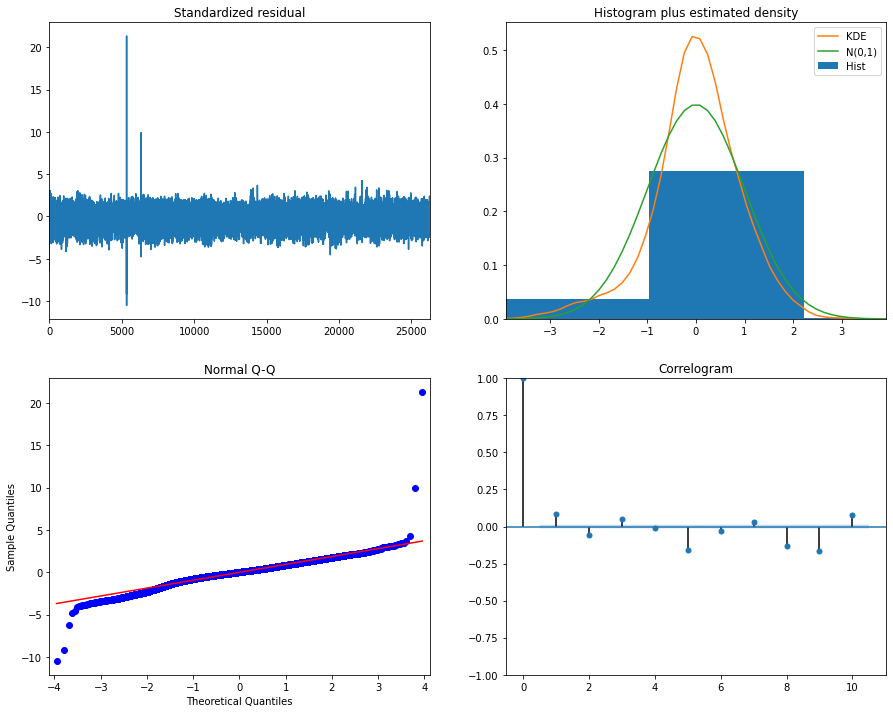

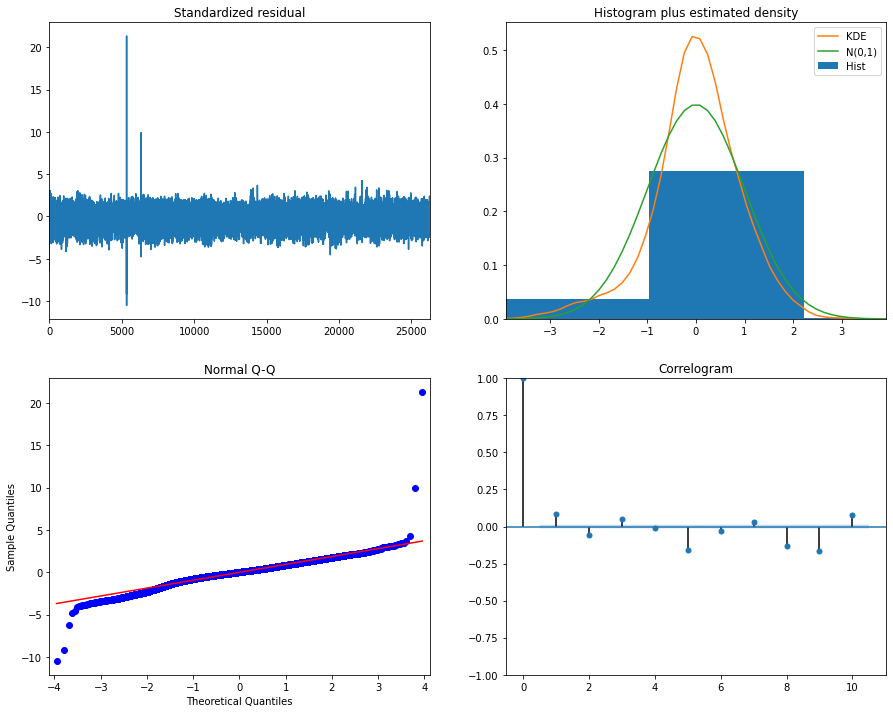

In [ ]:
arima_model.plot_diagnostics(figsize=(15, 12))

### Seasonal Arima Model
- Best orders of SARIMA Model is found by tuning the parameters with `autoarima` function
- Periodicity of 12 was used instead of 24 due to computation constraint
- Model does  captures seasonal variation in the data


In [ ]:
import time
t0 = time.time()
model_name='SARIMA'
sarima_model = auto_arima(y_train, start_p=1, start_q=0,
                          max_p=10, max_q=3,
                          seasonal=True, m=12,
                          d=None, trace=True,random_state=101,
                          out_of_sample_size=48,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)
sarima_model.summary() #ARIMA(3,1,0)(2,0,1)[12] intercept   : AIC=358529.096#ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=358609.012#Best model:  ARIMA(2,1,0)(0,0,2)[24

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=411211.919, Time=1.85 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=385452.265, Time=19.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=391248.375, Time=37.98 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=411209.919, Time=0.70 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=385494.572, Time=4.19 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=135.08 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=385479.226, Time=15.32 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=358822.634, Time=257.08 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=326.01 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=365861.323, Time=197.04 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=358609.012, Time=324.65 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=80.65 sec
 ARIMA(2,1,0)(

In [ ]:
#train
sarima_model.fit(y_train)
t1 = time.time()-t0
#predict
y_pred = sarima_model.predict(n_periods=48)
print('SMAPE: ',smape(y_test, y_pred))
print("Execution time: ", t1)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                 load   No. Observations:                26256
Model:             SARIMAX(3, 1, 0)x(2, 0, [1], 12)   Log Likelihood             -180139.676
Date:                              Mon, 05 Jul 2021   AIC                         360295.352
Time:                                      08:20:10   BIC                         360360.757
Sample:                                           0   HQIC                        360316.472
                                            - 26256                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature   254.7037      4.315     59.029      0.000     246.247     263.161
ar.L1           

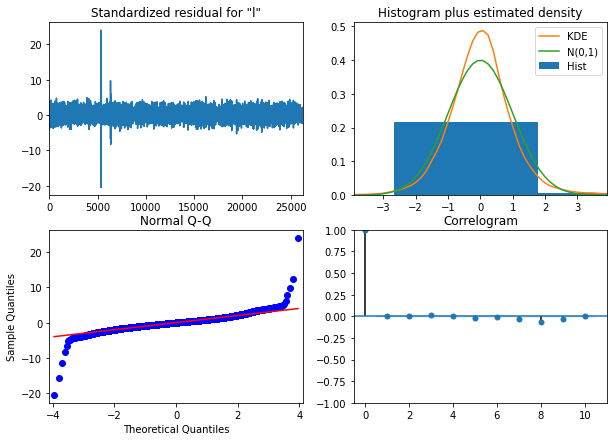

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Train model
model = SARIMAX(y_train,X_train, order = (3,1,0), seasonal_order = (2,0,1,12)).fit()

# Model summary 
print(model.summary())

# Model diagnostics
model.plot_diagnostics(figsize=(10,7))
plt.show()

In [ ]:
#predict
y_pred = model.predict(n_periods=48,X=X_test)
#print('SMAPE: ',smape(y_test, y_pred))

In [ ]:
#y_train.index=pd.Int64Index(data=y_train.index)
y_pred = pd.Series(y_pred) # convet ndarray to pd series
y_pred.index = y_test.index

26256

### Seasonal Arima Model with Exogenous Variable
- Best orders of SARIMAX Model is found by tuning the parameters with `autoarima` function
- Periodicity of 12 was used instead of 24 due to computation constraint
- Model does  captures seasonal variation in the data
- Model could be improved with more tuning of parameters


In [ ]:
import time
t0 = time.time()
model_name='SARIMAX'
sarimax_model = auto_arima(y_train,exogenous=X_train, start_p=1, start_q=0,
                          max_p=4, max_q=3,
                          seasonal=True, m=12,
                          d=None, trace=True,random_state=101,
                          out_of_sample_size=48,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)
sarimax_model.summary() # SARIMAX(1, 1, 0)x(2, 0, [1], 12) 	AIC 360072.459

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=142.71 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=407501.222, Time=2.39 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=384876.112, Time=46.01 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=389051.565, Time=62.80 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=407499.221, Time=9.87 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=384887.791, Time=18.28 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=244.42 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=384885.478, Time=39.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=360072.459, Time=316.63 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=136.12 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=250.03 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=366452.150, Time=262.74 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=360266.723, Time=368.31 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=360331.112, Time=316.01 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                26256
Model:             SARIMAX(1, 1, 0)x(2, 0, [1], 12)   Log Likelihood             -180029.229
Date:                              Mon, 05 Jul 2021   AIC                         360072.459
Time:                                      01:41:29   BIC                         360129.688
Sample:                                           0   HQIC                        360090.939
                                            - 26256                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0212      1.498      0.014      0.989      -2.914       2.957
x1           220.8701      4.266     51.780      0.000     212.510     229.230
ar.L1          0.5209      0.003    199.593      0.000       0.516       0.526
ar.S.L12      -0.0274      0.004     -6.376      0.000      -0.036      -0.019
ar.S.L24       0.8102      0.002    435.548      0.000       0.807       0.814
ma.S.L12       0.0771      0.007     10.539      0.000       0.063       0.091
sigma2      5.082e+04    191.533    265.346      0.000    5.04e+04    5.12e+04
===================================================================================
Ljung-Box (L1) (Q):                  73.60   Jarque-Bera (JB):            554243.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

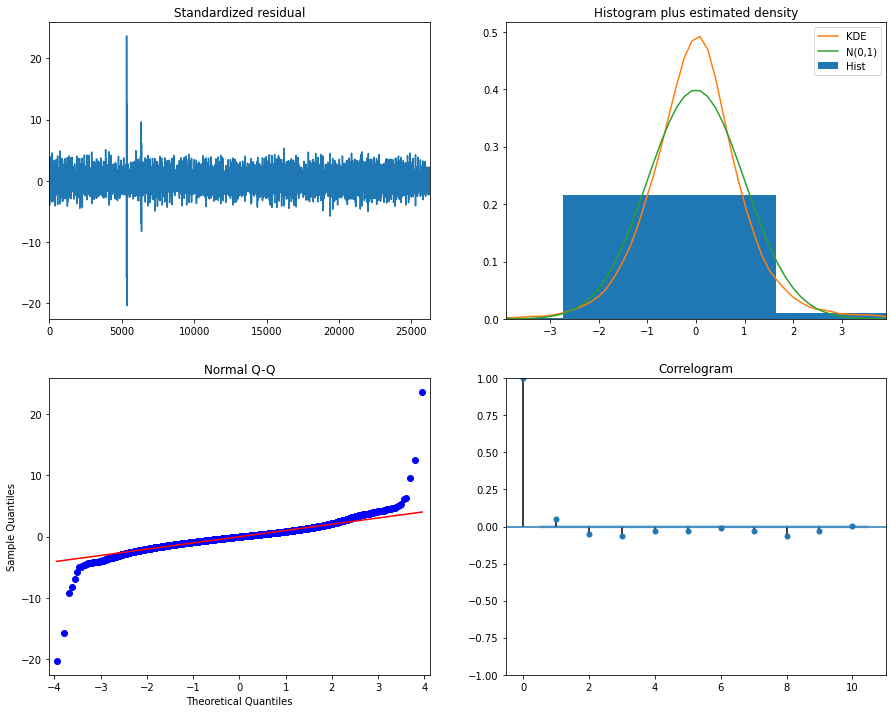

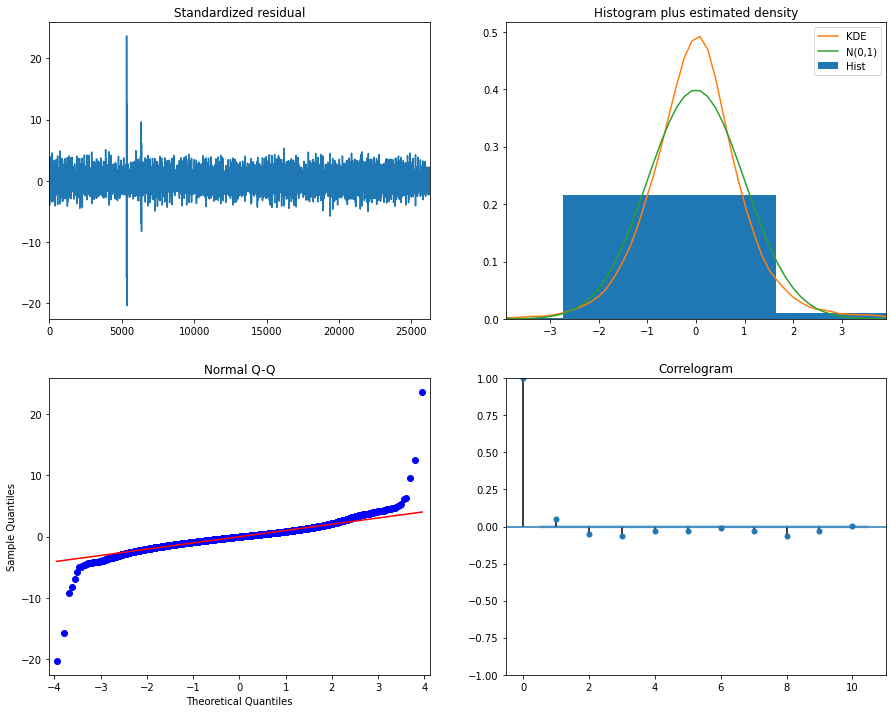

In [ ]:
sarimax_model.plot_diagnostics(figsize=(15, 12))

In [ ]:
#train
sarimax_model.fit(y_train,X_train)
t1 = time.time()-t0
#predict
y_pred = sarimax_model.predict(n_periods=48,X=X_test,)
print('SMAPE: ',smape(y_test, y_pred))
print("Execution time: ", t1)

SMAPE:  0.22182063084640968
Execution time:  6039.914550304413


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0aff1a2ad0>)

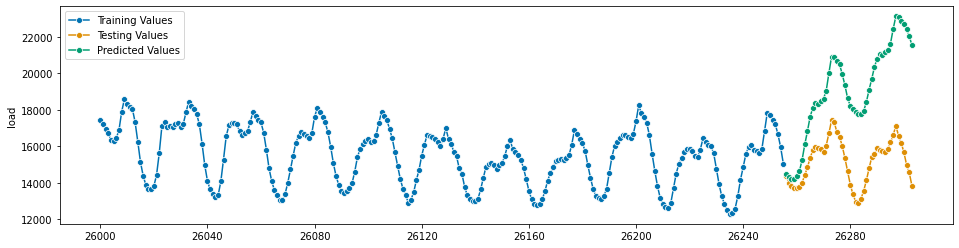

In [ ]:
#y_train.index=pd.Int64Index(data=y_train.index)
y_pred = pd.Series(y_pred) # convet ndarray to pd series
y_pred.index = y_test.index
plot_series(y_train[26000:], y_test,y_pred , labels = ["Training Values", "Testing Values", "Predicted Values"])

**Model Evaluation**

### 4.9. Define function to evaluate models


- MAPE (Mean absolute percentage error)
 - With MAPE the difference between each forecasted point and the actual value of that point is computed. The error per point is the quatified by calculating the proportion of the difference relative to the actual value.
 - MAPE is scale sensitive and should not be used when working with low-volume data. Also, MAPE is undefned when actual demand is zero. When the actual value is not zero, but quite small, the MAPE will often take on extreme values. This scale sensitivity renders the MAPE close to worthless as an error measure for low-volume data.

- SMAPE (Symmetric Mean absolute percentage error)
 - SMAPE is a variation on the MAPE that is calculated using the average of the absolute value of the actual and the absolute value of the forecast in the denominator. This statistic is preferred to the MAPE by some and was used as an accuracy measure in several forecasting competitions (Lazzeri F.,2021). It is easier to compare, benchmark or communicate with non-technical people due to percentage representative.


- MAE (Mean Absolute Error)
 - This measures the absolute error rate of the
forecast.

- RMSE (Root Mean Squared Error)
 - This is the root of the average squared
distance of the actual and forecasted values


- Performance metrics



In [ ]:
mape = MeanAbsolutePercentageError(symmetric=False)
smape = MeanAbsolutePercentageError(symmetric=True)
mae = MeanAbsoluteError()
mse = MeanSquaredError(square_root = False)
rmse = MeanSquaredError(square_root = True)

- Evaluate the Models on the evaluation metrics

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
listOfRegressors = ['SARIMAX',DecisionTreeRegressor(), RandomForestRegressor(n_estimators=30),
                   LinearRegression(), KNeighborsRegressor(n_neighbors=2),SVR()]




loss = {"MAE":[],"MSE":[],"RMSE":[],"MAPE":[],"SMAPE":[]}
regressorList = ['SARIMAX','DecisionTree', 'RandomForest', 'Linear', 'KNN','SVR']

for regressor in listOfRegressors:
  if (regressor == 'SARIMAX'):
    
    model = SARIMAX(y_train,exog = X_train, order =(1,1,0), seasonal_order = (2,0,1,12)).fit()
    y_pred = model.predict(start=y_test.index[0],end = y_test.index[-1],exog=X_test)
  
  else:


    reduced_reg = make_reduction(estimator = regressor, window_length=15)
    reduced_reg.fit(y_train, X_train, fh=fh)
    y_pred = reduced_reg.predict(fh,X = X_test)

  loss["MAE"].append(mae(y_test, y_pred))
  loss["MSE"].append(mse(y_test, y_pred))
  loss["RMSE"].append(rmse(y_test, y_pred))
  loss["MAPE"].append(mape(y_test, y_pred))
  loss["SMAPE"].append(smape(y_test, y_pred))

lossdata = pd.DataFrame(loss, index = regressorList) 
print(lossdata)  

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                      MAE           MSE         RMSE      MAPE     SMAPE
SARIMAX       2325.456975  6.982438e+06  2642.430291  0.152815  0.139112
DecisionTree  1514.625000  3.364683e+06  1834.307169  0.101461  0.098309
RandomForest  1354.115972  2.319879e+06  1523.114788  0.087850  0.083300
Linear         762.434329  8.755488e+05   935.707631  0.052138  0.050248
KNN            604.041667  5.499433e+05   741.581615  0.039375  0.039047
SVR           1182.238815  2.258436e+06  1502.809397  0.082844  0.077809


### References

- Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. https://otexts.com/fpp2/. Accessed on May 2021.
- Lazzeri, Francesca. 2021. Machine Learning for Time Series Forecasting with Python

- https://www.machinelearningplus.com/time-series/time-series-analysis-python/
- https://github.com/alan-turing-institute/sktime

- https://gist.github.com/Deffro/e54bdb90dd1c1392fc85e1db1cfbab7d
- https://www.kaggle.com/chandrimad31/m5-forecasting-different-time-series-models

